In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

from copy import copy
from typing import List, Optional, Union, Tuple, Callable, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.hooks import RemovableHandle

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


In [2]:
class FeatureExtractor(nn.Module):
    
    # https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904
    
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self.valid_name = [name for name, _ in self.model.named_children()]

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        self.handle[layer_id].remove()
        return fn
      
    def forward(self, x: torch.Tensor, layers: List[str]) -> Dict[str, torch.Tensor]:
        self._check_valid_inp(layers)
        self.handle = {layer_id: RemovableHandle(lambda x: _) for layer_id in layers}
        self._features = {layer_id: torch.empty(0) for layer_id in layers}
        for layer_id in layers:
            layer = dict(self.model.named_children())[layer_id]
            hook = self.save_outputs_hook(layer_id)
            self.handle[layer_id] = layer.register_forward_hook(hook)
        _ = self.model(x)
        return [self._features[layer_id] for layer_id in layers]
    
    def _check_valid_inp(self, inp):
        if isinstance(inp, str):
            self._is_in_layers(inp)
            inp = [inp]
        elif isinstance(inp, list):
            for i in inp:
                self._is_in_layers(i)
        else:
            raise AttributeError(f'type(inp): str or list')
        return copy(inp) # from copy import copy
    
    def _is_in_layers(self, name):
        if name not in self.valid_name:
            raise AttributeError(f'{name} not in self.valid_name.')

In [3]:
# VGG definition that conveniently let's you grab the outputs from any layer
  
class VGG(nn.Module):
    
    def __init__(
        self, 
        in_channels: int=3, 
        n_layers_per_block: List[int]=[2, 2, 4, 4, 4],
        n_channels_per_block: List[int]=[64, 128, 256, 512, 512],
        pool: str='max',
    ):
        super().__init__()
        
        assert len(n_layers_per_block) == len(n_channels_per_block)
        self.num_blocks = len(n_layers_per_block)
        
        loop = zip(n_layers_per_block, n_channels_per_block)
        for ix, (block, channels) in enumerate(loop, start=1):
            out_channels = channels
            for block_ix in range(1, block+1):
                if block_ix == 2: in_channels = channels
                setattr(self, f'conv{ix}_{block_ix}',
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            pool = 'MaxPool2d' if pool.lower() == 'max' else 'AvgPool2d'
            setattr(self, f'pool{ix}', getattr(nn, pool)(kernel_size=2, stride=2))
            in_channels = out_channels        
        
    def forward(self, x: torch.Tensor):
        for layer in self.children():
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                x = torch.relu(x)
        return x

In [4]:
#get network
vgg = FeatureExtractor(VGG())
vgg.model.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [6]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose(
    [transforms.Resize(img_size), # Image Re-size
     transforms.ToTensor(), # To Tensor
     transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # BGR Format
     transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961],
                          std=[1,1,1]), # Image Normalization
     transforms.Lambda(lambda x: x.mul_(255)), # Return 0~255
    ])

postpa = transforms.Compose(
    [transforms.Lambda(lambda x: x.mul_(1./255)), # Rescale
     transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],
                          std=[1,1,1]), # Image Normalization
     transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # turn to RGB
    ])

postpb = transforms.Compose([transforms.ToPILImage()])

def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t = torch.relu(t)
    img = postpb(t)
    return img

In [16]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G
    

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [21]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']

imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]

if torch.cuda.is_available():
    imgs_torch = [img.unsqueeze(0).cuda() for img in imgs_torch]
else:
    imgs_torch = [img.unsqueeze(0) for img in imgs_torch]
    
style_image, content_image = imgs_torch

opt_img = content_image.data.clone()
opt_img.requires_grad=True

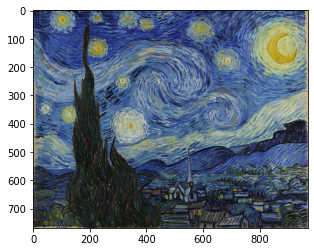

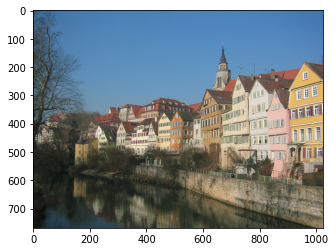

In [22]:
#display images
for img in imgs:
    imshow(img);show()

In [23]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1', 'conv5_1'] 
content_layers = ['conv4_2']

In [52]:
# define layers, loss functions, weights and compute optimization targets
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
# these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets

style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

Iteration: 50, loss: 627643.875000
Iteration: 100, loss: 373023.250000
Iteration: 150, loss: 309701.187500
Iteration: 200, loss: 282335.937500
Iteration: 250, loss: 267294.250000
Iteration: 300, loss: 257460.390625
Iteration: 350, loss: 251001.000000
Iteration: 400, loss: 245973.390625
Iteration: 450, loss: 242294.031250
Iteration: 500, loss: 239596.500000


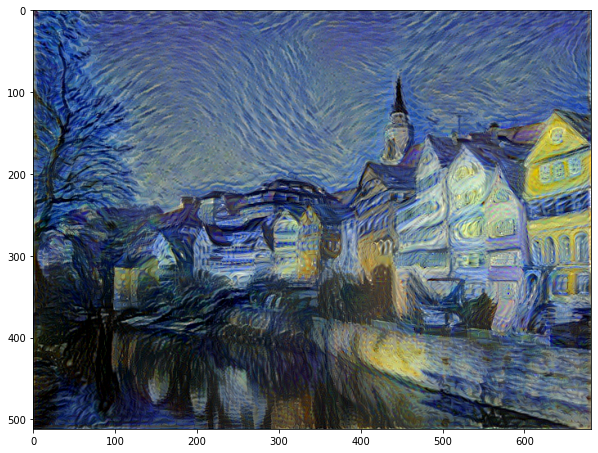

In [59]:
#run style transfer
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter = [0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a])
                        for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        if n_iter[0]%show_iter == (show_iter-1):
            print(f'Iteration: {n_iter[0]+1:03d}, loss: {loss.item():f}')
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

```python
#make the image high-resolution as described in 
#"Controlling Perceptual Factors in Neural Style Transfer", Gatys et al. 
#(https://arxiv.org/abs/1611.07865)

#hr preprocessing
img_size_hr = 800 #works for 8GB GPU, make larger if you have 12GB or more
prep_hr = transforms.Compose([transforms.Scale(img_size_hr),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
#prep hr images
imgs_torch = [prep_hr(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [img.unsqueeze(0).cuda() for img in imgs_torch]
else:
    imgs_torch = [img.unsqueeze(0) for img in imgs_torch]
style_image, content_image = imgs_torch

#now initialise with upsampled lowres result
opt_img = prep_hr(out_img).unsqueeze(0)
opt_img = opt_img.type_as(content_image.data)
opt_img.requires_grad = True

#compute hr targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets
```

```python
#run style transfer for high res 
max_iter_hr = 200
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]
while n_iter[0] <= max_iter_hr:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)
    
#display result
out_img_hr = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img_hr)
gcf().set_size_inches(10,10)
```